In [1]:
#Importing Packages
import numpy as np
from tqdm import tqdm
from tinygp import kernels, GaussianProcess,transforms
from jax import random, vmap, jit
import matplotlib.pyplot as plt
import skgstat as skg
import pandas as pd
from sklearn.linear_model import LinearRegression
from src.model_fitting_functions import run_inference,run_inference_tinygp,tinygp_example_model,tinygp_2process_example_model

import arviz as az
import jax.numpy as jnp

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [2]:
#Loading Data and Fitting Models

X = np.arange(0,20,0.1)
mask = np.ones(len(X),dtype='bool')
mask[slice(int(len(X)/3),int(len(X)*2/3))]=False
X_masked = X[mask]

GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=1e-5)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(3),X[::10],diag=1e-1)
GP2_cond = GP2.condition(Y[::10], X).gp
Y2 = GP2_cond.sample(rng_key)-1

GP3 = GaussianProcess(1 * kernels.ExpSquared(2),X[::10],diag=1e-1)
noise = np.random.normal(0,1,len(Y[::10]))
GP3_cond = GP3.condition(Y[::10]+noise, X).gp
Y3 = GP3_cond.sample(rng_key)

GP_masked = GaussianProcess(1 * kernels.ExpSquared(1),X_masked,diag=1e-5)
Y_masked = Y[mask]

modelY2 = LinearRegression().fit(Y2[mask].reshape(-1,1),Y_masked)
Y_pred_Y2_linear = modelY2.predict(Y2.reshape(-1,1))

model = LinearRegression().fit(Y3[mask].reshape(-1,1),Y_masked)
Y_pred_Y3_linear = model.predict(Y3.reshape(-1,1))

model = LinearRegression().fit(np.dstack([Y2[mask],Y3[mask]]).reshape(-1,2),Y_masked)
Y_pred_Y2Y3_linear = model.predict(np.dstack([Y2,Y3]).reshape(-1,2))

GP_Cond = GP_masked.condition(Y_masked, X).gp
Y_pred_samples = GP_Cond.sample(rng_key,(100,))
Y_pred_mean = Y_pred_samples.mean(axis=0)
Y_pred_std = Y_pred_samples.std(axis=0)

#cokriging
def mean_func(value):
    GP2_cond = GP2.condition(Y[::10], jnp.array([value])).gp
    Y2_pred = GP2_cond.sample(rng_key)
    mean = modelY2.intercept_ + modelY2.coef_ * Y2_pred
    return(mean[0])

GPCK_masked = GaussianProcess(1 * kernels.ExpSquared(1),X_masked,diag=1e-5,mean=mean_func)
GPCK_Cond = GPCK_masked.condition(Y_masked, X).gp
YCK_pred_samples = GPCK_Cond.sample(rng_key,(100,))
YCK_pred_mean = YCK_pred_samples.mean(axis=0)
YCK_pred_std = YCK_pred_samples.std(axis=0)

GPS_masked = GaussianProcess(1 * kernels.ExpSquared(1),X_masked[::10],diag=1e-5)
GPS_Cond = GPS_masked.condition(Y_masked[::10], X).gp
YS_pred_samples = GPS_Cond.sample(rng_key,(100,))
YS_pred_mean = YS_pred_samples.mean(axis=0)
YS_pred_std = YS_pred_samples.std(axis=0)

#bayesian
mcmc = run_inference_tinygp(tinygp_example_model, rng_key_, 1000, 2000, jnp.array(Y_masked[::10]), X=jnp.array(X_masked[::10]))
idata = az.from_numpyro(mcmc)

posterior = idata.posterior
YB_pred_samples = []
for i in tqdm(range(100)):
    kern_var = posterior['kern_var'].data[0,i]
    # like_var = posterior['like_var'].data[0,i]
    lengthscale = posterior['lengthscale'].data[0,i]
    kernel = kern_var * kernels.ExpSquared(lengthscale)
    mean = posterior['mean'].data[0,i]
    # gp = GaussianProcess(kernel, X_masked[::10], diag=like_var+1e-5, mean=mean)
    gp = GaussianProcess(kernel, X_masked[::10], mean=mean)
    gp_cond = gp.condition(Y_masked[::10], X).gp
    gp_sample = gp_cond.sample(rng_key,(100,))
    YB_pred_samples.append(gp_sample)
YB_pred_mean = np.array(YB_pred_samples).mean(axis=(0,1))
YB_pred_std = np.array(YB_pred_samples).std(axis=(0,1))


[-0.5293836  -0.05695832 -0.5115665  -1.2367804  -0.82326066 -0.23805448
  0.2839666  -0.12012275 -1.2759197  -0.8671782   0.15837383 -0.72754806
 -1.0558262  -1.3873639 ]
[-0.5293836  -0.05695832 -0.5115665  -1.2367804  -0.82326066 -0.23805448
  0.2839666  -0.12012275 -1.2759197  -0.8671782   0.15837383 -0.72754806
 -1.0558262  -1.3873639 ]


  0%|          | 0/3000 [00:00<?, ?it/s]

[-0.5293836  -0.05695832 -0.5115665  -1.2367804  -0.82326066 -0.23805448
  0.2839666  -0.12012275 -1.2759197  -0.8671782   0.15837383 -0.72754806
 -1.0558262  -1.3873639 ]


sample: 100%|██████████| 3000/3000 [00:05<00:00, 559.35it/s, 7 steps of size 3.53e-01. acc. prob=0.75] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     kern_var      1.42      1.07      1.11      0.20      2.75    478.92      1.00
  lengthscale      1.05      0.21      1.08      0.75      1.39    408.40      1.00
         mean     -0.54      0.43     -0.55     -1.21      0.17    562.99      1.00

Number of divergences: 1
Time Taken: 6.994263529777527
[-0.5293836  -0.05695832 -0.5115665  -1.2367804  -0.82326066 -0.23805448
  0.2839666  -0.12012275 -1.2759197  -0.8671782   0.15837383 -0.72754806
 -1.0558262  -1.3873639 ]
[-0.5293836  -0.05695832 -0.5115665  -1.2367804  -0.82326066 -0.23805448
  0.2839666  -0.12012275 -1.2759197  -0.8671782   0.15837383 -0.72754806
 -1.0558262  -1.3873639 ]


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


In [3]:
cdata = jnp.array((Y+Y2)[::5])
cx = jnp.array(X[::5])
odata = jnp.array((Y)[::20])
ox = jnp.array(X[::20])
print(cdata.shape,cx.shape,odata.shape,ox.shape)

mcmc = run_inference(tinygp_2process_example_model, rng_key_, 1000, 2000, cx,ox=ox,cdata=cdata,odata=odata)


(40,) (40,) (10,) (10,)


sample: 100%|██████████| 3000/3000 [13:43<00:00,  3.64it/s, 1023 steps of size 2.10e-06. acc. prob=0.77]



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
 bias_temperature[0]      1.01      0.00      1.01      1.01      1.01      0.50      1.00
 bias_temperature[1]     -0.44      0.00     -0.44     -0.44     -0.44      2.53      2.73
 bias_temperature[2]      1.68      0.00      1.68      1.68      1.68      0.50      1.00
 bias_temperature[3]     -1.71      0.00     -1.71     -1.71     -1.71      0.50      1.00
 bias_temperature[4]     -1.27      0.00     -1.27     -1.27     -1.27      0.50      1.00
 bias_temperature[5]     -1.08      0.00     -1.08     -1.08     -1.08      0.50      1.00
 bias_temperature[6]      1.64      0.00      1.64      1.64      1.64      0.50      1.00
 bias_temperature[7]      1.55      0.00      1.55      1.55      1.55      0.50      1.00
 bias_temperature[8]      0.24      0.00      0.24      0.24      0.24      5.27      1.07
 bias_temperature[9]     -1.47      0.00     -1.47     -1.47     -1.47      0.50      1.0

In [4]:
idata = az.from_numpyro(mcmc)

In [5]:
idata.posterior.mean(['chain','draw'])

<xarray.Dataset>
Dimensions:                 (bias_temperature_dim_0: 40)
Coordinates:
  * bias_temperature_dim_0  (bias_temperature_dim_0) int64 0 1 2 3 ... 37 38 39
Data variables:
    bias_temperature        (bias_temperature_dim_0) float32 1.006 ... 1.925
    bkern_var               float32 4.411
    blengthscale            float32 0.2592
    bmean                   float32 1.01
    kern_var                float32 0.8679
    lengthscale             float32 0.7023
    mean                    float32 1.369

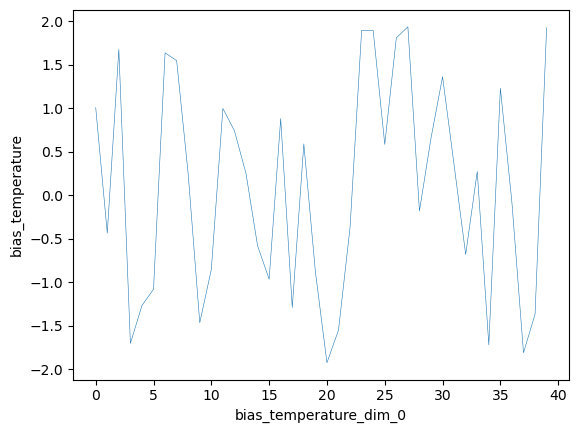

In [6]:
idata.posterior.mean(['chain','draw']).bias_temperature.plot()

In [ ]:
def tinygp_2process_example_model(cx,ox=None,cdata=None,odata=None):


In [3]:
jnp.array(Y_masked[::10]).shape

(14,)

In [12]:
mcmc = run_inference_tinygp(tinygp_example_model, rng_key_, 1000, 2000, jnp.array(Y_masked[::10]), X=jnp.array(X_masked[::10]))


warmup:  12%|█▏        | 368/3000 [00:02<00:18, 145.71it/s, 15 steps of size 4.36e-01. acc. prob=0.79]


KeyboardInterrupt: 

In [4]:
def correlation(A,B):
    diff_mean_A = A-A.mean()
    diff_mean_B = B-B.mean()
    product_of_differences = diff_mean_A*diff_mean_B
    average_pod = product_of_differences.mean()
    #note cov = average_pod
    correlation = average_pod/(A.std()*B.std())
    return(correlation)

In [28]:
lags = []
correlations = []

for j in np.arange(1,50,1):
    lag = (X_masked[1]-X_masked[0])*j
    X_adjusted = X_masked-lag
    compatible_mask = np.array([i in X_masked for i in X_adjusted])
    args = [np.argwhere(X_masked == k) for k in X_adjusted[compatible_mask]]
    Y_adjusted = np.array([Y_masked[arg] for arg in args])[:,0,0]
    cor = correlation(Y_masked[compatible_mask],Y_adjusted)
    
    lags.append(lag)
    correlations.append(cor)

Text(0, 0.5, 'temperature')

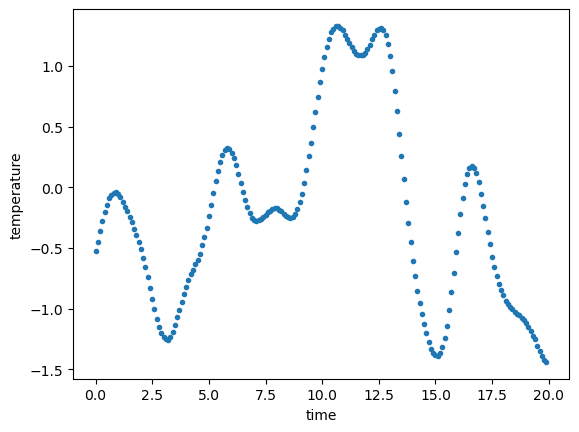

In [21]:
###Plot 1
plt.scatter(X,Y)
plt.xlabel('time')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

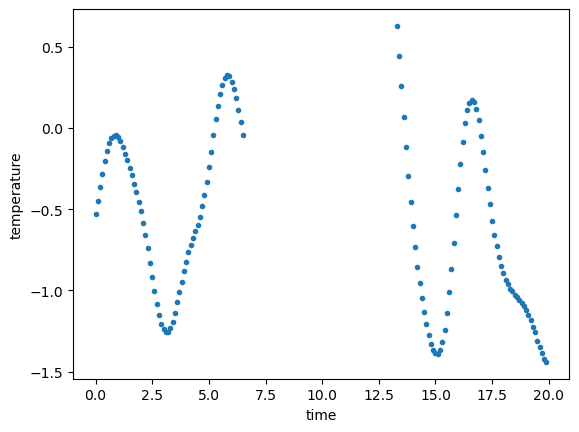

In [22]:
###Plot 2
plt.scatter(X_masked,Y_masked)
plt.xlabel('time')
plt.ylabel('temperature')

Correlation = $\dfrac{E[(x-\bar{x})(y-\bar{y})]}{\sigma_x \cdot \sigma_y}$ 

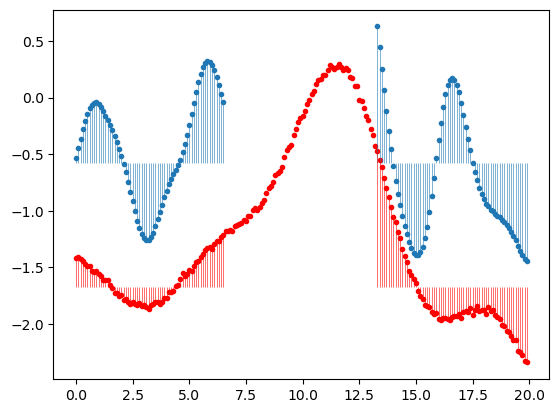

In [58]:
plt.scatter(X_masked,Y_masked)
plt.scatter(X,Y2,color='r')

plt.vlines(X_masked,Y_masked,Y_masked.mean())
plt.vlines(X_masked,Y2[mask],Y2[mask].mean(),color='r')


# plt.fill_between(X_masked,Y_masked,Y_masked.mean(),where = X_masked)

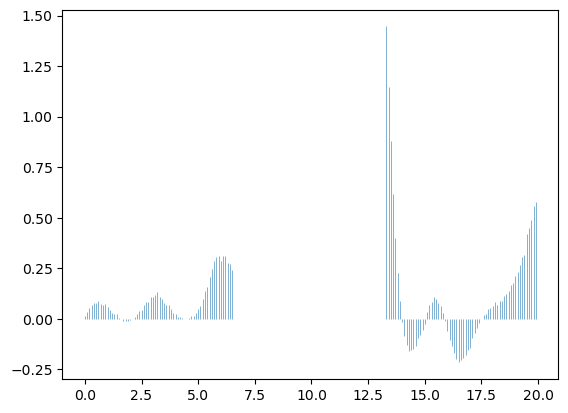

In [60]:
product_of_differences = (Y_masked-Y_masked.mean())*(Y2[mask]-Y2[mask].mean())
plt.vlines(X_masked,0,product_of_differences)

Text(17.5, 1, 'Correlation = 0.54')

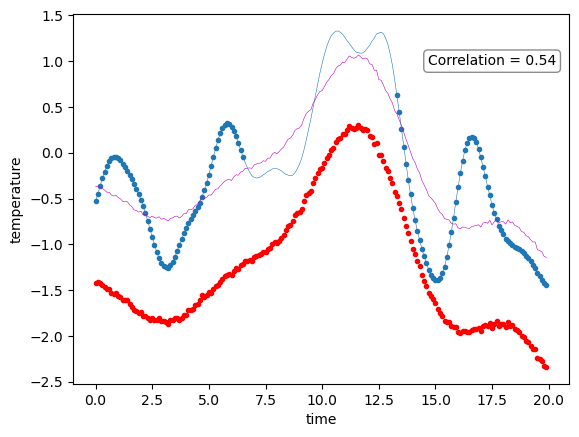

In [23]:
###Plot 3
plt.scatter(X_masked,Y_masked)
plt.scatter(X,Y2,color='r')
plt.plot(X,Y)
plt.plot(X,Y_pred_Y2_linear,color='m')
plt.xlabel('time')
plt.ylabel('temperature')
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
plt.gca().text(17.5, 1, "Correlation = "+"{:.2f}".format(correlation(Y2[mask],Y_masked)), ha="center", va="center", size=10,bbox=bbox_props)

Text(17.5, 0.5, 'Correlation = 0.82')

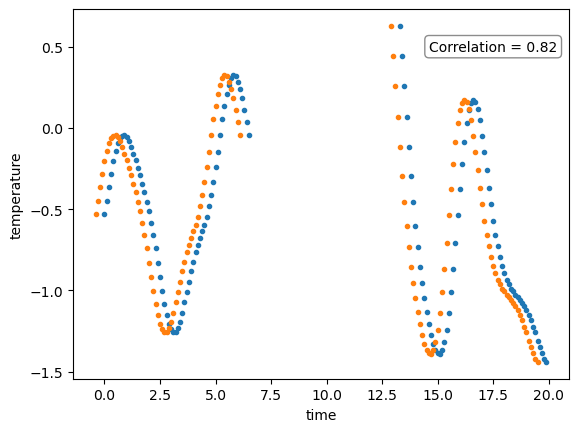

In [52]:
###Plot 4
plt.scatter(X_masked,Y_masked)
plt.scatter(X_masked-0.4,Y_masked)
plt.xlabel('time')
plt.ylabel('temperature')

correlation = correlations[np.argwhere(np.array(lags)==0.4)[0][0]]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
plt.gca().text(17.5, 0.5, "Correlation = "+"{:.2f}".format(correlation), ha="center", va="center", size=10,bbox=bbox_props)

Text(0, 0.5, 'auto-correlation')

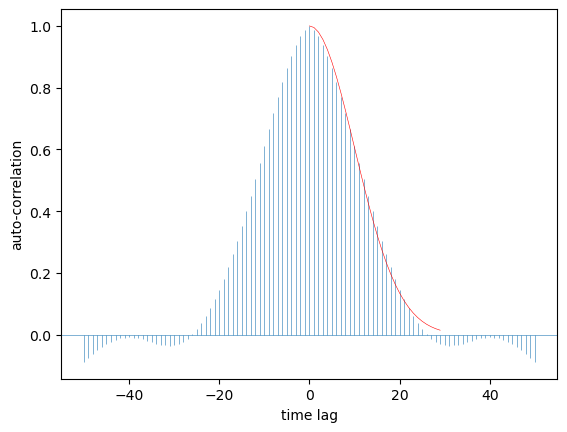

In [105]:
###Plot 5
plt.acorr(Y, maxlags = 50)

ks = []
for lag in np.arange(0,3,0.1):
    k = np.exp(-(lag**2)/2)
    ks.append(k)

plt.plot(np.arange(0,30,1),ks,color='r')

# plt.scatter(lags,correlations)
plt.xlabel('time lag')
plt.ylabel('auto-correlation')

Text(0, 0.5, 'temperature')

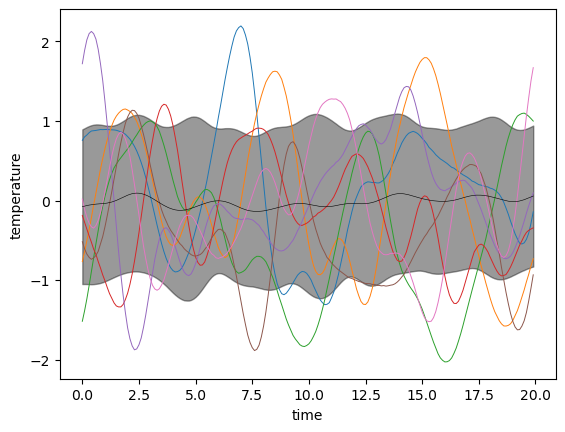

In [262]:
#Example GP
GP = GaussianProcess(1 * kernels.ExpSquared(1),X,diag=1e-5)

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
samples = GP.sample(rng_key,(100,))
samples_mean = samples.mean(axis=0)
samples_std = samples.std(axis=0)

for sample in samples[::15]:
    plt.plot(X,sample,linewidth=0.7)
plt.plot(X,samples_mean,color='k')
plt.fill_between(X, samples_mean-samples_std, samples_mean+samples_std,color='k',alpha=0.4)

plt.xlabel('time')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

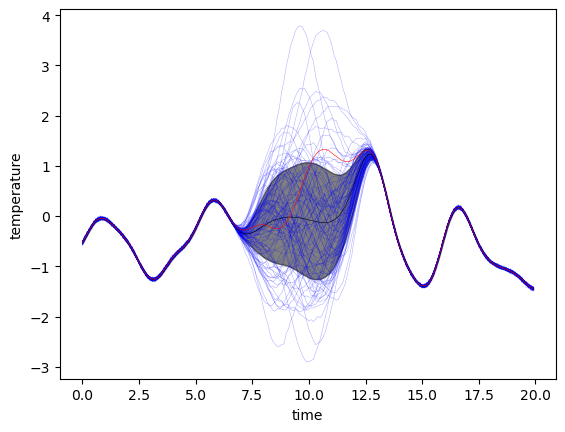

In [20]:
### Conditioned GP
for sample in Y_pred_samples:
    plt.plot(X,sample,color='b',alpha=0.3)
plt.plot(X,Y_pred_mean,color='k')
plt.fill_between(X, Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,color='k',alpha=0.5)
plt.plot(X,Y,color='r')
plt.xlabel('time')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

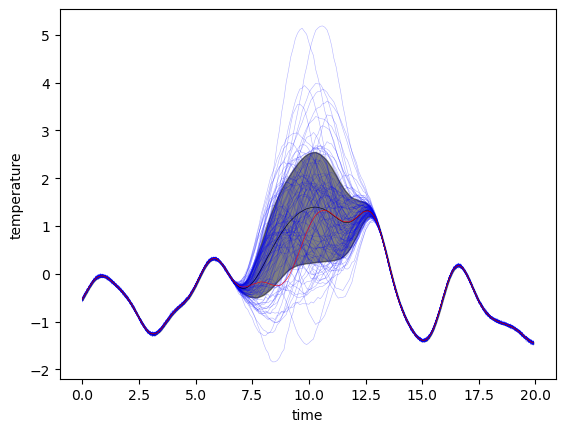

In [21]:
### Cokriging GP
for sample in YCK_pred_samples:
    plt.plot(X,sample,color='b',alpha=0.3)
plt.plot(X,YCK_pred_mean,color='k')
plt.fill_between(X, YCK_pred_mean-YCK_pred_std, YCK_pred_mean+YCK_pred_std,color='k',alpha=0.5)

plt.plot(X,Y,color='r')
plt.xlabel('time')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

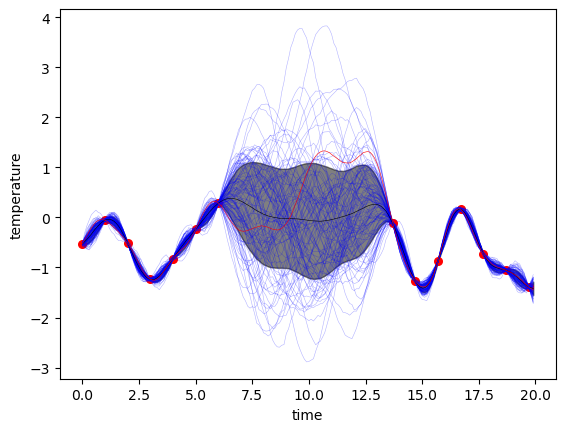

In [22]:
### Sparse Samples
for sample in YS_pred_samples:
    plt.plot(X,sample,color='b',alpha=0.3)
plt.plot(X,YS_pred_mean,color='k')
plt.fill_between(X, YS_pred_mean-YS_pred_std, YS_pred_mean+YS_pred_std,color='k',alpha=0.5)
plt.plot(X,Y,color='r')
plt.scatter(X_masked[::10],Y_masked[::10],color='r',s=30)

plt.xlabel('time')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

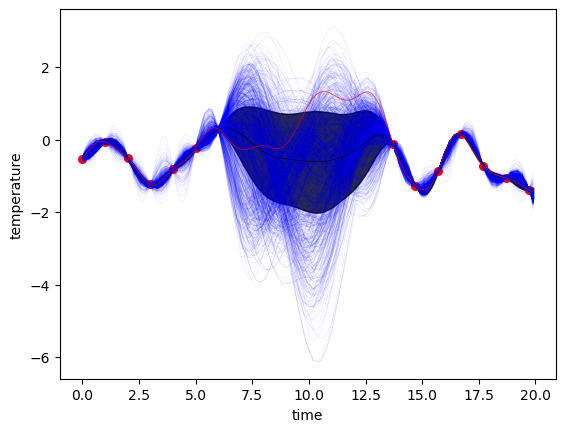

In [23]:
### Bayesian GP Sparse Example
for sample_collection in YB_pred_samples:
    for sample in sample_collection[::10]:
        plt.plot(X,sample,color='b',alpha=0.1)
plt.plot(X,YB_pred_mean,color='k')
plt.fill_between(X, YB_pred_mean-YB_pred_std, YB_pred_mean+YB_pred_std,color='k',alpha=0.8)
plt.plot(X,Y,color='r')
plt.scatter(X_masked[::10],Y_masked[::10],color='r',s=30)
plt.xlabel('time')
plt.ylabel('temperature')

Text(0, 0.5, 'temperature')

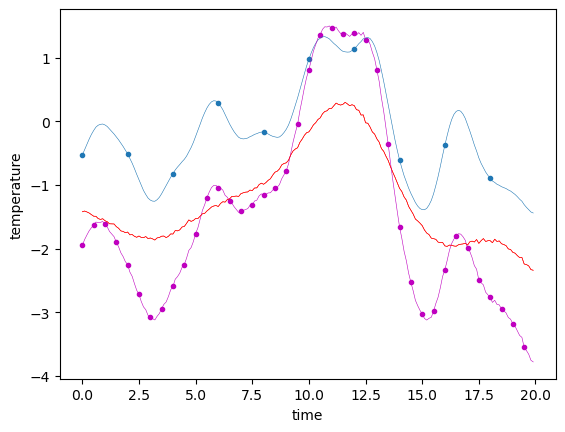

In [11]:
###Plot 3
plt.scatter(X[::20],Y[::20])
# plt.scatter(X[::3],Y2[::3],color='r')
plt.plot(X,Y)
plt.plot(X,Y2,color='r')
plt.scatter(X[::5],(Y+Y2)[::5],color='m')
plt.plot(X,Y+Y2,color='m')
plt.plot(X,Y2,color='r')

plt.xlabel('time')
plt.ylabel('temperature')

In [ ]:
def tinygp_2process_example_model(cx,ox=None,cdata=None,odata=None):
    """
   Example model where the climate data is generated from 2 GPs, one of which also generates the observations and one of which generates bias in the climate model.
    Args:
        cx (jax device array): array of coordinates for climate model, shape [#gridcells,dimcoords]
        ox (jax device array): array of coordinates for observations, shape [#sites,dimcoords]
        cdata (jax device array): array of data values for climate model, shape [#gridcells,]
        odata (jax device array): array of data values for observations, shape [#sites,]
    """

    #GP that generates the bias
    bkern_var = numpyro.sample("bkern_var", dist.Gamma(3.0,0.5))
    blengthscale = numpyro.sample("blengthscale", dist.Gamma(3.0,0.5))
    bkernel = bkern_var * kernels.ExpSquared(blengthscale)
    bmean = numpyro.sample("bmean", dist.Normal(0.0, 2.0))
    bgp = GaussianProcess(bkernel, cx, mean=bmean)
    bias = numpyro.sample("bias_temperature", bgp.numpyro_dist()) 

    #GP that generates the truth (& so the observations directly)
    kern_var = numpyro.sample("kern_var", dist.Gamma(3.0,0.5))
    lengthscale = numpyro.sample("lengthscale", dist.Gamma(3.0,0.5))
    kernel = kern_var * kernels.ExpSquared(lengthscale)
    mean = numpyro.sample("mean", dist.Normal(0.0, 2.0))
    gp = GaussianProcess(kernel, ox, mean=mean)
    obs = numpyro.sample("obs_temperature", gp.numpyro_dist(),obs=odata)

    #Conditional GP for evaluating the likelihood of the climate data
    gp_cond = gp.condition(odata, cx).gp
    climatetruth = numpyro.sample("climatetruth_temperature", gp_cond.numpyro_dist(),obs=cdata)

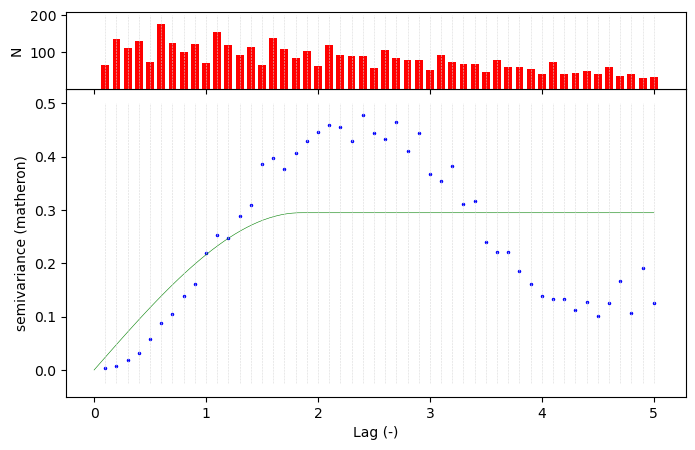

In [69]:
###Plot 6 
coords = X[mask].reshape(-1)
semivariogram = skg.Variogram(coords, Y[mask],n_lags=50,maxlag=5)#bin_func='uniform',maxlag=5)
semivariogram.plot()#axes=axs[:,params.index(param)][::-1])
plt.show()

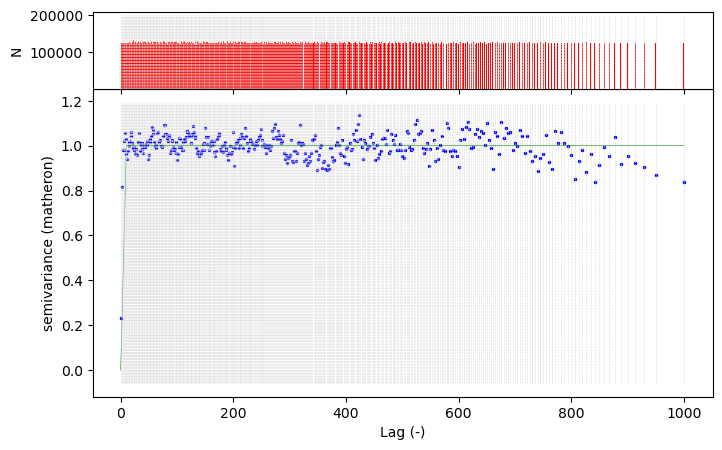

In [139]:
coords = X.reshape(-1)
semivariogram = skg.Variogram(coords, Y,n_lags=400,bin_func='uniform')
semivariogram.plot()#axes=axs[:,params.index(param)][::-1])
plt.show()

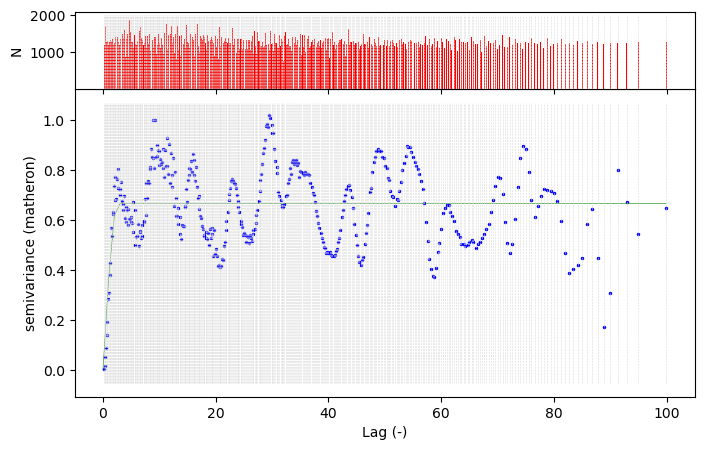

In [137]:
# fig = plt.figure(figsize=(30,15))

coords = X.reshape(-1)
semivariogram = skg.Variogram(coords, Y,n_lags=400,bin_func='uniform')
semivariogram.plot()#axes=axs[:,params.index(param)][::-1])
plt.show()

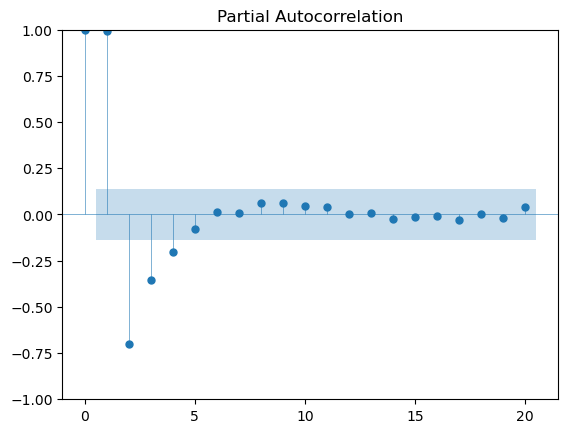

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(Y, lags=20)